In [1]:
%load_ext autoreload 
%autoreload 2
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import scipy 

# from GS_training import * 

import openfermion

In [129]:
def find_groundstate(N, p, state_circuit, H, max_iterations = 300, conv_tol = 1e-06, param = None, lr = 0.4):
    # call device 
    dev = qml.device("default.qubit", wires = N )
    
    #define cost function find expectation value of Hamiltonian which is energy for parametrized state 
    @qml.qnode(dev, interface='autograd')
    def cost_fn(param):
        state_circuit(param*np.pi, w = range(N))
        return qml.expval(H)
    # define optimizer
    opt = qml.GradientDescentOptimizer(stepsize = lr)
    
    # start with random parameter 
    # if param is None: 
    param = np.random.randn(p, 6, N, requires_grad = True) # size is define through state circuit 

    energy = [cost_fn(param)]
    for n in range(max_iterations):
        param, prev_energy = opt.step_and_cost(cost_fn, param)
        # print(param)
        energy.append(cost_fn(param))
        conv = np.abs(energy[-1]-prev_energy)
        # print(n)
        if n%20 ==0 : 
            print(f"current energy{energy[-1]:.8f}")
        if  conv <= conv_tol:
            print("conserved")
            break
    return energy, param

def eYXmXY(theta, wires):
    # wires = [0,1]
    qml.CNOT(wires=wires)
    qml.SWAP(wires=wires)
    
    qml.CRY(-theta, wires = wires)
    qml.SWAP(wires=wires)
    
    qml.CNOT(wires = wires)
    
def eXXpYY(theta, wires):
    # wires = [0,1]
    qml.RY(np.pi/2, wires= wires[0])
    qml.RZ(np.pi/2, wires= wires[1])
    qml.CNOT(wires = wires)
    qml.RY(theta, wires= wires[0])
    qml.RY(theta, wires= wires[1])
    qml.CNOT(wires = wires)
    qml.RY(-np.pi/2, wires= wires[0])
    qml.RZ(-np.pi/2, wires= wires[1])
    
def eM3(theta, wires):
    U = np.array([[0,0,0,0], [0,np.exp(-1j*theta),0,0],[0,0,-np.exp(1j*theta),0],[0,0,0,0]])
    qml.QubitUnitary(U, wires= wires)
    
def Pcircuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    
    # print(param.shape)
    p = len(param)
    # (p, _)  = param.shape
    N = len(w)
    # parametrized circuit with depth p 
    
    hf = qml.qchem.hf_state(6, N)
    qml.BasisState(hf, wires=w)
    # qml.DoubleExcitation(param, wires=w[0,1,2,3])
    
    for step in range(p):
        for i in range(N):  
            qml.RZ(param[step, 0, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            eXXpYY(param[step, 1, i],wires = w[i: i+2])
            eYXmXY(param[step,2, i],wires = w[i: i+2])
            # eM3(param[step, 5, i], wires = w[i:i+2])
            eYXmXY(param[step,3, i],wires = w[i: i+2])
            eXXpYY(param[step, 4, i],wires = w[i: i+2])
        
        # eXXpYY(param[step, 1, N-1],wires = [w[N-1], w[0]])
        # eYXmXY(param[step,2, N-1],wires = [w[N-1], w[0]])
        # eM3(param[step, 3, N-1], wires = [w[N-1], w[0]])
        # eYXmXY(param[step,4, N-1],wires = [w[N-1], w[0]])
        # eXXpYY(param[step, 5, N-1],wires = [w[N-1], w[0]])


In [130]:
symbols = ["N", "N"]
dist = 2.0741632451
geometry = np.array([[0.0, 0.0, 0], 
                        [0.0, 0.0, dist]], requires_grad = False)
H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, method="pyscf", active_electrons=6,
    active_orbitals=6)
N = qubits
p = 40

# param = np.random.randn(p, 3, N, requires_grad = True)
# print(param.shape)

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  12
The Hamiltonian is    (-104.76539580159103) [I0]
+ (-0.47289102832661645) [Z10]
+ (-0.4728910283266164) [Z11]
+ (-0.08842306915567125) [Z8]
+ (-0.0884230691556712) [Z9]
+ (-0.08842306915567084) [Z7]
+ (-0.08842306915567046) [Z6]
+ (0.1239733562040163) [Z5]
+ (0.12397335620401642) [Z4]
+ (0.135539065723716) [Z3]
+ (0.1355390657237162) [Z2]
+ (0.13553906572371777) [Z0]
+ (0.13553906572371793) [Z1]
+ (0.10006894937577682) [Z2 Z8]
+ (0.10006894937577682) [Z3 Z9]
+ (0.1000689493757769) [Z0 Z6]
+ (0.1000689493757769) [Z1 Z7]
+ (0.12246926963332817) [Z2 Z4]
+ (0.12246926963332817) [Z3 Z5]
+ (0.12246926963332828) [Z0 Z4]
+ (0.12246926963332828) [Z1 Z5]
+ (0.12564216681297008) [Z4 Z8]
+ (0.12564216681297008) [Z5 Z9]
+ (0.12564216681297014) [Z4 Z6]
+ (0.12564216681297014) [Z5 Z7]
+ (0.12569151698946815) [Z4 Z10]
+ (0.12569151698946815) [Z5 Z11]
+ (0.12909087979750763) [Z0 Z2]
+ (0.12909087979750763) [Z1 Z3]
+ (0.12948675751650174) [Z2 Z5]
+ (0.12948675751650174) [Z3 Z4]
+ 

In [131]:
energy_list, param = find_groundstate(N, p, Pcircuit, H, max_iterations=300,conv_tol = 10**(-6), lr = 0.005)

current energy-106.44048568
current energy-107.48020679
current energy-107.49123843
current energy-107.49360882
current energy-107.49460764
current energy-107.49511999
current energy-107.49540597
current energy-107.49557441
current energy-107.49567753
current energy-107.49574246
current energy-107.49578420
current energy-107.49581142
conserved


/home/iqsl/anaconda3/envs/domino/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


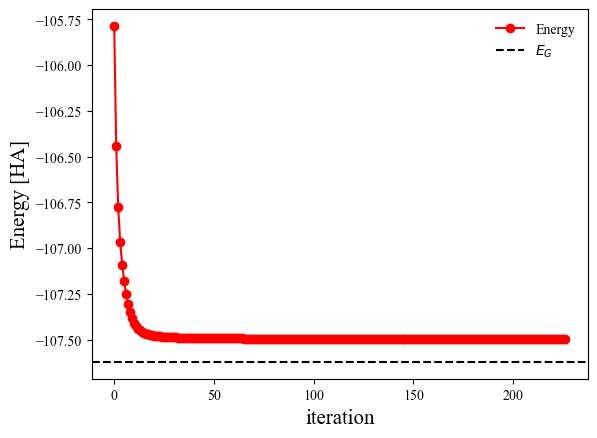

In [133]:
# p = 6 num of electrons = 6 
plt.Figure(figsize=(20,18))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(energy_list, '-o', c= 'red', label ='Energy')
plt.axhline(y = E_g, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('Energy [HA]', fontsize = 15)
plt.legend(frameon=False)

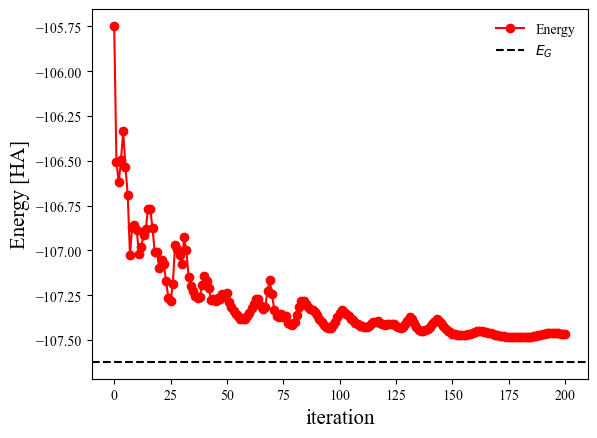

In [126]:
# p = 6 num of electrons = 6 
plt.Figure(figsize = (20,18))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(energy_list, '-o', c= 'red', label ='Energy')
plt.axhline(y = E_g, c = 'k', linestyle = '--', label = '$E_G$')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('Energy [HA]', fontsize = 15)
plt.legend(frameon=False)

In [127]:
energy_list[-1]

tensor(-107.46848905, requires_grad=True)

In [111]:

Hmat = qml.utils.sparse_hamiltonian(H)
d, _ = scipy.sparse.linalg.eigs(-Hmat)
E_g = -np.max(d)

/home/iqsl/anaconda3/envs/domino/lib/python3.10/site-packages/pennylane/utils.py:67: UserWarning: The method sparse_hamiltonian is deprecated. Please use the method sparse_matrix of the Hamiltonian operator instead.
  warnings.warn(


In [123]:
E_g

(-107.62179339170982-1.0464129489915483e-15j)